In [1]:
# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set device to gpu if available
import torch
device = 'cpu'
if torch.cuda.is_available:
  print('All good, a Gpu is available')
  device = torch.device("cuda:0")  
else:
  print('Please set GPU via Edit -> Notebook Settings.')
  

All good, a Gpu is available


In [3]:
!nvidia-smi

Mon May 23 15:00:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install -q torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-geometric
!pip install -q ogb

     |████████████████████████████████| 7.9 MB 9.6 MB/s 
     |████████████████████████████████| 3.5 MB 7.9 MB/s 
     |████████████████████████████████| 407 kB 10.4 MB/s 
     |████████████████████████████████| 78 kB 4.5 MB/s 


In [5]:
# Import modules
import networkx as nx
from torch_geometric.utils.convert import to_networkx

import tqdm
import time
import sys
import os
import math
import random

import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch_geometric.utils import negative_sampling

import numpy as np

import pandas as  pd

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import cm, colors

from ogb.linkproppred import PygLinkPropPredDataset, Evaluator

import torch_geometric.transforms as T
from torch_sparse import SparseTensor
from torch_geometric.nn import GCNConv, SAGEConv

from sklearn.metrics import roc_auc_score

## Reproducibility
When **developing and debugging** Neural Networks is desirable to have a deterministic behaviour. For this reason, we are going to disable all the sources of randomness. Please note that completely reproducible results are not guaranteed across PyTorch releases, individual commits or different platforms. You can find more detailed information at this [page](https://pytorch.org/docs/stable/notes/randomness.html).
Please note that the flag `cudnn.benchmark = False` disable the auto-tuner that selects the optimal set of algorithms for your hardware and usually leads to slower runtime. 

In [6]:
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True        

In [7]:
fix_random(42)

## The Dataset

In [8]:
dataset = PygLinkPropPredDataset(name="ogbl-ddi", root='datasets/')
evaluator = Evaluator(name='ogbl-ddi')

Downloaded 0.04 GB: 100%|██████████| 46/46 [00:00<00:00, 54.65it/s]


Extracting datasets/ddi.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 35.46it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 6786.90it/s]

Saving...



Done!


In [9]:
data = dataset[0]
edge_index = data.edge_index.to(device)
if data.x is not None:
    data.x = data.x.to(torch.float)
if data.edge_weight is not None:
    data.edge_weight = data.edge_weight.view(-1).to(torch.float)

transform = T.Compose([
    # T.NormalizeFeatures(),
    T.RemoveIsolatedNodes(),
    T.ToSparseTensor(),
])
data = transform(data)

In [10]:
print()
print(f'Dataset: {dataset.name}:')
print('==================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print()
print(data)
print('=======================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: ogbl-ddi:
Number of graphs: 1
Number of features: 0
Number of classes: 0

Data(num_nodes=4267, adj_t=[4267, 4267, nnz=2135822])
Number of nodes: 4267
Number of edges: 2135822
Average node degree: 500.54
Has isolated nodes: False
Has self-loops: False
Is undirected: True


##Model Definition

In [11]:
from torch.nn import Sequential, Linear, Dropout

class GCN(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, n_layers, p_drop, skip_conn=False, post_proc_MLP=False):
        super(GCN, self).__init__()

        if n_layers < 1:
            raise AssertionError('Number or convolution layer must be at least 1')

        self.p_drop = p_drop
        self.n_layers = n_layers
        self.skip_conn = skip_conn

        self.convs = torch.nn.ModuleList()
        for i in range(n_layers):
            conv = GCNConv(in_dim, hid_dim, normalize=True)
            in_dim = hid_dim
            self.convs.append(conv)

        self.post_proc_MLP = post_proc_MLP
        if post_proc_MLP:
            self.post_MLP = Sequential(
                Linear(in_dim, hid_dim), Dropout(self.p_drop),
                Linear(hid_dim, out_dim)
            )
        else:
            self.convs[-1] = GCNConv(in_dim, out_dim, normalize=True)

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        if self.post_proc_MLP:
            self.post_MLP.reset_parameters()

    def forward(self, x, adj_t):
        x_prev = None
        for conv in self.convs[:-1]:
            x = conv(x, adj_t)

            if self.skip_conn and x_prev is not None:
                x = x + x_prev
            
            x = F.relu(x)
            x = F.dropout(x, p=self.p_drop, training=self.training)
            x_prev = x
            
        if self.post_proc_MLP:
            x = self.convs[-1](x, adj_t)
            x = self.post_MLP(x)
        else:
            x = self.convs[-1](x, adj_t)

        return x

In [12]:
from torch.nn import Sequential, Linear, Dropout
class SAGE(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, n_layers, p_drop, skip_conn=False, post_proc_MLP=False):
        super(SAGE, self).__init__()

        if n_layers < 1:
            raise AssertionError('Number or convolution layer must be at least 1')

        self.p_drop = p_drop
        self.n_layers = n_layers
        self.skip_conn = skip_conn

        self.convs = torch.nn.ModuleList()
        for i in range(n_layers):
            conv = SAGEConv(in_dim, hid_dim, normalize=True, aggr="add")
            in_dim = hid_dim
            self.convs.append(conv)

        self.post_proc_MLP = post_proc_MLP
        if post_proc_MLP:
            self.post_MLP = Sequential(
                Linear(in_dim, hid_dim), Dropout(self.p_drop),
                Linear(hid_dim, out_dim)
            )
        else:
            self.convs[-1] = SAGEConv(in_dim, out_dim, normalize=True, aggr="add")

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        if self.post_proc_MLP:
            self.post_MLP.reset_parameters()

    def forward(self, x, adj_t):
        x_prev = None
        for conv in self.convs[:-1]:
            x = conv(x, adj_t)

            if self.skip_conn and x_prev is not None:
                x = x + x_prev
            
            x = F.relu(x)
            x = F.dropout(x, p=self.p_drop, training=self.training)
            x_prev = x
            
        if self.post_proc_MLP:
            x = self.convs[-1](x, adj_t)
            x = self.post_MLP(x)
        else:
            x = self.convs[-1](x, adj_t)

        return x

In [13]:
class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout, aggr="product"):
        super(LinkPredictor, self).__init__()

        self.aggr = aggr

        self.lins = torch.nn.ModuleList()
        if self.aggr == "product":
            self.lins.append(torch.nn.Linear(in_channels, hidden_channels))
        elif self.aggr == "concatenation":
            self.lins.append(torch.nn.Linear(in_channels*2, hidden_channels))
        else:
            raise ValueError('No valid aggreation. Valid aggregation methods are: [product, concatenation]')
        for _ in range(num_layers - 2):
            self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(torch.nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        if self.aggr == "product":
            x = torch.mul(x_i, x_j)
        else: # self.aggr == "concatenation"
            x = torch.cat((x_i, x_j), dim=-1)
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return torch.sigmoid(x)

## Train and evaluation

The model is trained by jointly maximizing the probabilty prediction of correct edges and minimizing the probability prediciton of the incorrect edges:

$$Loss = -\log(prob\_pos\_edges  + ϵ) - \log(1-prob\_neg\_edges + ϵ)$$

where the $ϵ=10^{-15}$ is added to each term for numerical stability

In [14]:
def train(model, predictor, node_feats, adj_t, split_edge, optimizer, batch_size):
    model.train()
    predictor.train()

    pos_train_edge = split_edge['train']['edge'].to(device)

    total_loss = total_examples = 0
    for edge_id in DataLoader(range(pos_train_edge.size(0)), batch_size, shuffle=True):
        optimizer.zero_grad()

        node_emb = model(node_feats, adj_t)
        

        # Predict the class probabilities on the batch of positive edges using link_predictor
        pos_edge = pos_train_edge[edge_id].t()
        pos_pred = predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]])

        # Trivial random sampling.
        #neg_edge = torch.randint(0, node_feats.size(0), batch_size, dtype=torch.long, device=node_emb.device)
        # Sample negative edges (same number as number of positive edges) and predict class probabilities 
        neg_edge = negative_sampling(edge_index, num_nodes=node_feats.size(0), num_neg_samples=edge_id.size(0), method='sparse')
        neg_pred = predictor(node_emb[neg_edge[0]], node_emb[neg_edge[1]])

         # Compute the corresponding negative log likelihood loss on the positive and negative edges
        loss = - torch.log(pos_pred + 1e-15).mean() - torch.log(1 - neg_pred + 1e-15).mean()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(node_feats, 1.0)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)

        optimizer.step()

        num_examples = pos_pred.size(0)
        total_loss += loss.item() * num_examples
        total_examples += num_examples

    return total_loss / total_examples

The performance of a link predictor is evaluated through the metric Hits@K.

Hits@K = Fraction of correct links in the top K links (with respect to their scores)

In [15]:
@torch.no_grad()
def test(model, predictor, data, adj_t, split_edge, evaluator, batch_size):
    model.eval()
    predictor.eval()

    h = model(data, adj_t)

    pos_train_edge = split_edge['train']['edge'].to(h.device)
    pos_valid_edge = split_edge['valid']['edge'].to(h.device)
    neg_valid_edge = split_edge['valid']['edge_neg'].to(h.device)
    pos_test_edge = split_edge['test']['edge'].to(h.device)
    neg_test_edge = split_edge['test']['edge_neg'].to(h.device)

    # ------------------ TRAIN ------------------- #
    # Positive edges prediction
    pos_train_preds = []
    for perm in DataLoader(range(pos_train_edge.size(0)//10), batch_size, shuffle=True):
        edge = pos_train_edge[perm].t()
        pos_train_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    pos_train_pred = torch.cat(pos_train_preds, dim=0)

    # ---------------- VALIDATION ---------------- #
    # Positive edges prediction
    pos_valid_preds = []
    for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
        edge = pos_valid_edge[perm].t()
        pos_valid_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    pos_valid_pred = torch.cat(pos_valid_preds, dim=0)
    # Negative sampled edges prediction
    neg_valid_preds = []
    for perm in DataLoader(range(neg_valid_edge.size(0)), batch_size):
        edge = neg_valid_edge[perm].t()
        neg_valid_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    neg_valid_pred = torch.cat(neg_valid_preds, dim=0)

    # ------------------- TEST ------------------- #
    # Positive edges prediction
    pos_test_preds = []
    for perm in DataLoader(range(pos_test_edge.size(0)), batch_size):
        edge = pos_test_edge[perm].t()
        pos_test_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    pos_test_pred = torch.cat(pos_test_preds, dim=0)
    # Negative sampled edges prediction
    neg_test_preds = []
    for perm in DataLoader(range(neg_test_edge.size(0)), batch_size):
        edge = neg_test_edge[perm].t()
        neg_test_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    neg_test_pred = torch.cat(neg_test_preds, dim=0)
    
    results = {}
    # hits@K
    for K in [20, 50, 100]:
        evaluator.K = K
        train_hits = evaluator.eval({
            'y_pred_pos': pos_train_pred,
            'y_pred_neg': neg_valid_pred,
        })[f'hits@{K}']
        valid_hits = evaluator.eval({
            'y_pred_pos': pos_valid_pred,
            'y_pred_neg': neg_valid_pred,
        })[f'hits@{K}']
        test_hits = evaluator.eval({
            'y_pred_pos': pos_test_pred,
            'y_pred_neg': neg_test_pred,
        })[f'hits@{K}']

        results[f'hits@{K}'] = (round(train_hits,2), round(valid_hits,2), round(test_hits,2))

    return results  

In [16]:
USE_VAL_EDGES_AS_INPUT = False

BATCH_SIZE = 64 * 1024
INPUT_DIM = dataset.num_features
OUTPUT_DIM = dataset.num_classes
EPOCHS = 50

LR = 5e-3
WD = 1e-5
EVAL_STEPS = 5


split_edge = dataset.get_edge_split()

# Use training + validation edges for inference on test set.
if USE_VAL_EDGES_AS_INPUT:
    val_edge_index = split_edge['valid']['edge'].t()
    full_edge_index = torch.cat([edge_index, val_edge_index], dim=-1)
    data.full_adj_t = SparseTensor.from_edge_index(full_edge_index).t()
    data.adj_t = data.full_adj_t.to_symmetric()

data = data.to(device)

best_test_hits = 0
best_model_history = None
best_model_weight = None

from sklearn.model_selection import ParameterGrid
configs = {
    'USE_SAGE': [True, False],
    'USE_EMBEDDING_LAYER': [True],
    'HIDDEN_DIM' : [256],
    'DROPOUT' : [0.0],
    'N_LAYERS' : [2, 3],
    'SKIP_CONN' : [True],
    'POST_PROC_MLP' : [False],
    'LINK_PRED_AGGR': ['product', 'concatenation']
}
param_grid = ParameterGrid(configs)
print(f'Number of combinations: {len(param_grid)}')
print('------------------')
for dict_ in param_grid:
    print(f'Trying configuration {dict_}')
    parameter_list = []

    #INPUT DATA
    if dict_['USE_EMBEDDING_LAYER']:
        if data.x is not None:
            emb = torch.nn.Embedding(data.num_nodes, INPUT_DIM).to(device)
            emb.weight.data.copy_(data.x) # copy data features as initial embedding
        else:
            emb = torch.nn.Embedding(data.num_nodes, dict_['HIDDEN_DIM']).to(device)  
        input_data = emb.weight
        parameter_list += (list(emb.parameters()))
    else:
        input_data = data.x

    #MODEL
    if dict_['USE_SAGE']:
        model = SAGE(INPUT_DIM, dict_['HIDDEN_DIM'], dict_['HIDDEN_DIM'], dict_['N_LAYERS'], dict_['DROPOUT'], skip_conn=dict_['SKIP_CONN'], post_proc_MLP=dict_['POST_PROC_MLP']).to(device)
    else:
        model = GCN(INPUT_DIM, dict_['HIDDEN_DIM'], dict_['HIDDEN_DIM'], dict_['N_LAYERS'], dict_['DROPOUT'], skip_conn=dict_['SKIP_CONN'], post_proc_MLP=dict_['POST_PROC_MLP']).to(device)
    parameter_list += (list(model.parameters()))

    #LINK PREDICTOR
    link_predictor = LinkPredictor(dict_['HIDDEN_DIM'], dict_['HIDDEN_DIM'], 1,  3, dict_['DROPOUT'], aggr=dict_['LINK_PRED_AGGR']).to(device)
    parameter_list += (list(link_predictor.parameters()))

    optimizer = torch.optim.Adam(parameter_list, lr=LR, weight_decay=WD)

    #TRAIN & EVALUATE
    history = {}
    history['loss'] = []
    history['train_hits@20'] = []; history['train_hits@50'] = []; history['train_hits@100'] = []
    history['valid_hits@20'] = []; history['valid_hits@50'] = []; history['valid_hits@100'] = []
    history['test_hits@20']  = []; history['test_hits@50']  = []; history['test_hits@100']  = []
    pbar = tqdm.tqdm(range(EPOCHS))
    for epoch in pbar:
        loss = train(model, link_predictor, input_data, data.adj_t, split_edge, optimizer, BATCH_SIZE) 
        history['loss'].append(loss)

        if (epoch + 1) % EVAL_STEPS == 0 or epoch == 0:
            results = test(model, link_predictor, input_data, data.adj_t, split_edge, evaluator, BATCH_SIZE)
            for key, result in results.items():
                train_hits, valid_hits, test_hits = result
                history[f'train_{key}'].append(train_hits)
                history[f'valid_{key}'].append(valid_hits)
                history[f'test_{key}'].append(test_hits)

        description = f"Epoch {(epoch + 1):02d} - loss: {loss:.4f} - result: {results}\t"
        pbar.set_description(description, refresh=True)

    print('------------------')
    
    if max(history['test_hits@20']) > best_test_hits:
        best_parameters = dict_
        best_model_history = history
        best_model_weights = model.state_dict()
        best_test_hits = max(history['test_hits@20'])
    
    del model; del link_predictor
    torch.cuda.empty_cache()

Number of combinations: 8
------------------
Trying configuration {'DROPOUT': 0.0, 'HIDDEN_DIM': 256, 'LINK_PRED_AGGR': 'product', 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': True, 'USE_EMBEDDING_LAYER': True, 'USE_SAGE': True}


Epoch 50 - loss: 0.1880 - result: {'hits@20': (0.36, 0.3, 0.38), 'hits@50': (0.65, 0.57, 0.66), 'hits@100': (0.81, 0.75, 0.8)}	: 100%|██████████| 50/50 [05:24<00:00,  6.50s/it]


------------------
Trying configuration {'DROPOUT': 0.0, 'HIDDEN_DIM': 256, 'LINK_PRED_AGGR': 'product', 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': True, 'USE_EMBEDDING_LAYER': True, 'USE_SAGE': False}


Epoch 50 - loss: 0.2374 - result: {'hits@20': (0.46, 0.41, 0.23), 'hits@50': (0.57, 0.52, 0.39), 'hits@100': (0.67, 0.61, 0.54)}	: 100%|██████████| 50/50 [05:18<00:00,  6.38s/it]


------------------
Trying configuration {'DROPOUT': 0.0, 'HIDDEN_DIM': 256, 'LINK_PRED_AGGR': 'product', 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True, 'USE_EMBEDDING_LAYER': True, 'USE_SAGE': True}


Epoch 50 - loss: 0.4453 - result: {'hits@20': (0.16, 0.15, 0.07), 'hits@50': (0.28, 0.28, 0.18), 'hits@100': (0.36, 0.35, 0.32)}	: 100%|██████████| 50/50 [05:16<00:00,  6.33s/it]


------------------
Trying configuration {'DROPOUT': 0.0, 'HIDDEN_DIM': 256, 'LINK_PRED_AGGR': 'product', 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True, 'USE_EMBEDDING_LAYER': True, 'USE_SAGE': False}


Epoch 50 - loss: 0.2585 - result: {'hits@20': (0.31, 0.26, 0.17), 'hits@50': (0.45, 0.4, 0.31), 'hits@100': (0.56, 0.5, 0.47)}	: 100%|██████████| 50/50 [05:27<00:00,  6.56s/it]


------------------
Trying configuration {'DROPOUT': 0.0, 'HIDDEN_DIM': 256, 'LINK_PRED_AGGR': 'concatenation', 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': True, 'USE_EMBEDDING_LAYER': True, 'USE_SAGE': True}


Epoch 50 - loss: 0.2116 - result: {'hits@20': (0.33, 0.28, 0.17), 'hits@50': (0.53, 0.45, 0.36), 'hits@100': (0.66, 0.59, 0.51)}	: 100%|██████████| 50/50 [05:12<00:00,  6.25s/it]


------------------
Trying configuration {'DROPOUT': 0.0, 'HIDDEN_DIM': 256, 'LINK_PRED_AGGR': 'concatenation', 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': True, 'USE_EMBEDDING_LAYER': True, 'USE_SAGE': False}


Epoch 50 - loss: 0.2962 - result: {'hits@20': (0.32, 0.28, 0.17), 'hits@50': (0.45, 0.4, 0.3), 'hits@100': (0.53, 0.49, 0.43)}	: 100%|██████████| 50/50 [05:20<00:00,  6.41s/it]


------------------
Trying configuration {'DROPOUT': 0.0, 'HIDDEN_DIM': 256, 'LINK_PRED_AGGR': 'concatenation', 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True, 'USE_EMBEDDING_LAYER': True, 'USE_SAGE': True}


Epoch 50 - loss: 0.3303 - result: {'hits@20': (0.34, 0.3, 0.16), 'hits@50': (0.5, 0.46, 0.34), 'hits@100': (0.58, 0.55, 0.45)}	: 100%|██████████| 50/50 [05:23<00:00,  6.47s/it]


------------------
Trying configuration {'DROPOUT': 0.0, 'HIDDEN_DIM': 256, 'LINK_PRED_AGGR': 'concatenation', 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True, 'USE_EMBEDDING_LAYER': True, 'USE_SAGE': False}


Epoch 50 - loss: 0.2847 - result: {'hits@20': (0.36, 0.3, 0.09), 'hits@50': (0.47, 0.4, 0.26), 'hits@100': (0.56, 0.5, 0.42)}	: 100%|██████████| 50/50 [05:28<00:00,  6.57s/it]

------------------


In [17]:
print(f'Best parameters: {best_parameters}')

Best parameters: {'DROPOUT': 0.0, 'HIDDEN_DIM': 256, 'LINK_PRED_AGGR': 'product', 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': True, 'USE_EMBEDDING_LAYER': True, 'USE_SAGE': True}


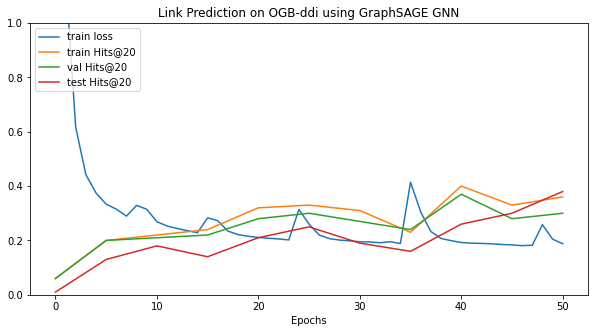

In [18]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1, EPOCHS+1), best_model_history['loss'], label="train loss")
plt.plot(np.arange(0, EPOCHS+1, EVAL_STEPS), best_model_history['train_hits@20'], label="train Hits@20")
plt.plot(np.arange(0, EPOCHS+1, EVAL_STEPS), best_model_history['valid_hits@20'], label="val Hits@20")
plt.plot(np.arange(0, EPOCHS+1, EVAL_STEPS), best_model_history['test_hits@20'], label="test Hits@20")
#plt.plot(np.arange(0, EPOCHS+1, 10), best_model_history['test_auc'], label="test auc")
plt.title('Link Prediction on OGB-ddi using GraphSAGE GNN')
plt.xlabel('Epochs')
plt.ylim(0., 1.)
plt.legend(loc='upper left')
plt.show()

## Evaluation of ML models

In [19]:
from community import community_louvain

data = dataset[0]
G = to_networkx(data, to_undirected=True)

# Features inferred from the graph topology
pagerank = torch.Tensor(list(nx.pagerank(G).values()))
louvain = torch.Tensor(list(community_louvain.best_partition(G).values()))
betweeness_centrality = torch.Tensor(list(nx.betweenness_centrality(G, k=50).values()))
degree = torch.Tensor([val for (node, val) in G.degree()])

X = torch.column_stack((pagerank, louvain, betweeness_centrality, degree))
print(f"N. features: {X.size(1)}")

N. features: 4


In [20]:
split_edge = dataset.get_edge_split()

In [21]:
pos_train_edge = split_edge['train']['edge']

# Select positive edges for train     
pos_edge = pos_train_edge.t()
X_train_pos = torch.cat((X[pos_edge[0]], X[pos_edge[1]]), dim=-1)

# Sample negative edges (same number as number of positive edges) for train
neg_edge = negative_sampling(data.edge_index, num_nodes=X.size(0), num_neg_samples=pos_edge.size(1), method='sparse')
X_train_neg = torch.cat((X[neg_edge[0]], X[neg_edge[1]]), dim=-1)

X_train = pd.DataFrame(torch.cat((X_train_pos, X_train_neg), dim=0).detach().numpy())
y_train = torch.cat((torch.ones(X_train_pos.size(0)), torch.zeros(X_train_neg.size(0))), dim=0).detach().numpy().reshape(-1,)
print(f'X_train\tshape: {X_train.shape}\ny_train\tshape: {y_train.shape}')

X_train	shape: (2135822, 8)
y_train	shape: (2135822,)


In [22]:
# Select positive edges for test 
pos_test_edge = split_edge['test']['edge'].t()
X_test_pos = torch.cat((X[pos_test_edge[0]], X[pos_test_edge[1]]), dim=-1)

# Select negative edges for test
neg_test_edge = split_edge['test']['edge_neg'].t()
X_test_neg = torch.cat((X[neg_test_edge[0]], X[neg_test_edge[1]]), dim=-1)

X_test = pd.DataFrame(torch.cat((X_test_pos, X_test_neg), dim=0).detach().numpy())
y_test = torch.cat((torch.ones(pos_test_edge.size(1)), torch.zeros(neg_test_edge.size(1))), dim=0).detach().numpy().reshape(-1,)
print(f'X_test\tshape: {X_test.shape}\ny_test\tshape: {y_test.shape}')

X_test	shape: (229088, 8)
y_test	shape: (229088,)


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Labels for the models
model_lbls = [
    'rf',   # Random Forest
    'xgb',  # eXtreme Gradient Boost
]

# Set the parameters to be explored for each classifier
tuned_param_rf = [
    {
        'n_estimators': [100],
        'max_depth': [50],
    },
]
tuned_param_xgb = [
    {
        'objective': ['binary:logistic'],
        'tree_method': ['gpu_hist'],
    },
]

# Set the models to be fitted specifying name, estimator and parameter structure
models = {
    # 'rf': {
    #     'name': 'Random Forest',
    #     'estimator': RandomForestClassifier(), 
    #     'param': tuned_param_rf,
    # },
    'xgb':{
        'name': 'XGBoost',
        'estimator': XGBClassifier(),
        'param': tuned_param_xgb,
    }
}

# Scores to be explored
scores = [
    'precision', 
    'recall',
]

In [24]:
from sklearn.metrics import accuracy_score, classification_report
def print_results(model):    
    print("Best parameters set found on train set:")
    print()
    print(model.best_params_)
    print()
    print("Grid scores on train set:")
    print()
    best_score = 0
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    for mean, std, param in zip(means, stds, model.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, param))
        if mean > best_score:
          best_score = mean
    print()

    # probability of each test edge to be positive
    y_prob = model.predict_proba(X_test)[:,1]
    # predicted probability for positive edges (where ground truth is 1)
    pos_test_pred = np.array(y_prob[y_test == 1])
    # predicted probability for negative edges (where ground truth is 0)
    neg_test_pred = np.array(y_prob[y_test == 0.])

    K = 20
    evaluator.K = K     
    test_hits = evaluator.eval({
        'y_pred_pos': pos_test_pred,
        'y_pred_neg': neg_test_pred,
    })[f'hits@{K}']
    test_hits = round(test_hits,2)
    print(f'Hits@{K} on test: {test_hits}\n')

    return best_score * 100

In [25]:
from sklearn.model_selection import GridSearchCV
for score in scores:
    print("========================================")
    print("# Tuning hyper-parameters for {}".format(score))
    for model in models:
        print("----------------------------------------")
        print("Trying model {}".format(models.get(model)["name"]))
        start = time.time()
        clf = GridSearchCV(models.get(model)["estimator"], models.get(model)["param"], scoring='%s_macro' % score)
        clf.fit(X_train, y_train)
        print_results(clf)
        end = time.time()
        print(f"Time elapsed: {(end - start):.2f}s")

# Tuning hyper-parameters for precision
----------------------------------------
Trying model XGBoost
Best parameters set found on train set:

{'objective': 'binary:logistic', 'tree_method': 'gpu_hist'}

Grid scores on train set:

0.838 (+/-0.008) for {'objective': 'binary:logistic', 'tree_method': 'gpu_hist'}

Hits@20 on test: 0.05

Time elapsed: 7.69s
# Tuning hyper-parameters for recall
----------------------------------------
Trying model XGBoost
Best parameters set found on train set:

{'objective': 'binary:logistic', 'tree_method': 'gpu_hist'}

Grid scores on train set:

0.836 (+/-0.007) for {'objective': 'binary:logistic', 'tree_method': 'gpu_hist'}

Hits@20 on test: 0.05

Time elapsed: 7.18s
